<a href="https://colab.research.google.com/github/rim-yu/SGU_ANT6320_Assignment/blob/master/Exercise07_pets_more.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lesson 6: pets revisited

데이터 보강은 가장 연구되지 않은 정규화 유형 중 하나. 데이터 기능 보강 및 일반화 향상. 훈련에 더 오래 걸리지 않고 어느 정도는 적합하지 않음. 컴퓨터 비전으로 돌아오는 것. 애완 동물 데이터세트로 돌아옴. 

https://course.fast.ai/videos/?lesson=6

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.vision import *

In [0]:
bs = 64

In [3]:
path = untar_data(URLs.PETS)/'images'

## Data augmentation

In [0]:
tfms = get_transforms(max_rotate=20, max_zoom=1.3, max_lighting=0.4, max_warp=0.4,
                      p_affine=1., p_lighting=1.)
# p_affine : affine이 발생할 확률을 제어하는 함수 파라미터. 
# p_lighting : 조명 효과 설정이 발생할 확률. 둘 다 1로 설정해서 모두 변환됨.
# 더 많은 회전, 줌, 조명 효과 등 더 많은 왜곡을 할 것임. 

In [5]:
doc(get_transforms)

In [0]:
src = ImageList.from_folder(path).split_by_rand_pct(0.2, seed=2)

In [0]:
def get_data(size, bs, padding_mode='reflection'):
    return (src.label_from_re(r'([^/]+)_\d+.jpg$')
           .transform(tfms, size=size, padding_mode=padding_mode)
           .databunch(bs=bs).normalize(imagenet_stats))

In [0]:
data = get_data(224, bs, 'zeros')

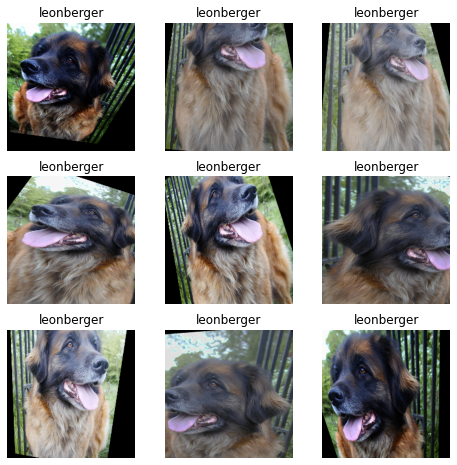

In [9]:
def _plot(i,j,ax):
    x,y = data.train_ds[3] # train dataset이기 때문에 data augmentation할 거임. 
    x.show(ax, y=y)

plot_multi(_plot, 3, 3, figsize=(8,8))

In [0]:
data = get_data(224, bs)

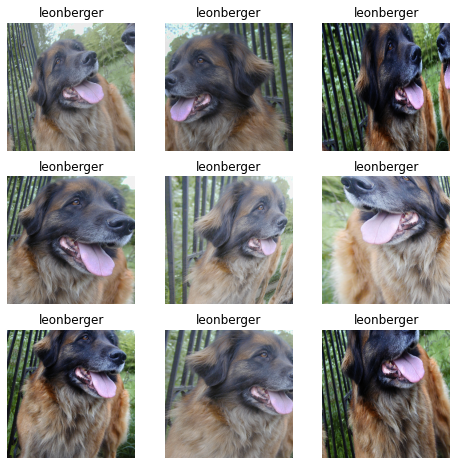

In [11]:
plot_multi(_plot, 3, 3, figsize=(8,8))

## Train a model

In [12]:
gc.collect()
# 각각의 데이터는 세대 정도를 가지고 있으며 세대 값이 낮을수록 가장 최근에 생성된 데이터라고 생각하면 됨. 
# 사용되지 않는 메모리를 해제. 메모리 해제를 재촉할 수 있는 것임. 빈번히 호출하는 건 속도저하 유발. 
# 필요없는 데이터를 메모리에서 지우는 것임.  
learn = cnn_learner(data, models.resnet34, metrics=error_rate, bn_final=True)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth


In [13]:
learn.fit_one_cycle(3, slice(1e-2), pct_start=0.8)

epoch,train_loss,valid_loss,error_rate,time
0,1.646411,0.383135,0.106901,01:53
1,0.975418,0.278687,0.081191,01:53
2,0.717988,0.253159,0.076455,01:52


In [14]:
learn.unfreeze()
learn.fit_one_cycle(2, max_lr=slice(1e-6,1e-3), pct_start=0.8)

epoch,train_loss,valid_loss,error_rate,time
0,0.580115,0.253379,0.069012,01:59
1,0.538586,0.237258,0.065629,01:59


In [0]:
data = get_data(352,bs)
learn.data = data

In [16]:
learn.fit_one_cycle(2, max_lr=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.505919,0.226223,0.050068,03:43
1,0.469456,0.219771,0.049391,03:41


In [0]:
learn.save('352')

## Convolution kernel

In [0]:
data = get_data(352,16)

In [0]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate, bn_final=True).load('352')

Category english_cocker_spaniel

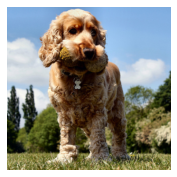

In [20]:
idx=0
x,y = data.valid_ds[idx]
x.show()
data.valid_ds.y[idx]

In [0]:
k = tensor([
    [0.  ,-5/3,1],
    [-5/3,-5/3,1],
    [1.  ,1   ,1],
]).expand(1,3,3,3)/6
# expand는 이것을 3번 복사해서 3*3*3 텐서를 구성함. 동일한 메모리 주소를 가리키는 것. 
# 4D는 여러 3D의 조합임. 

In [22]:
k # 우리의 4D 텐서. 

tensor([[[[ 0.0000, -0.2778,  0.1667],
          [-0.2778, -0.2778,  0.1667],
          [ 0.1667,  0.1667,  0.1667]],

         [[ 0.0000, -0.2778,  0.1667],
          [-0.2778, -0.2778,  0.1667],
          [ 0.1667,  0.1667,  0.1667]],

         [[ 0.0000, -0.2778,  0.1667],
          [-0.2778, -0.2778,  0.1667],
          [ 0.1667,  0.1667,  0.1667]]]])

In [23]:
k.shape

torch.Size([1, 3, 3, 3])

In [24]:
t = data.valid_ds[0][0].data; t.shape # 원본 사이즈. 

torch.Size([3, 352, 352])

In [25]:
t[None].shape

torch.Size([1, 3, 352, 352])

In [0]:
edge = F.conv2d(t[None], k)

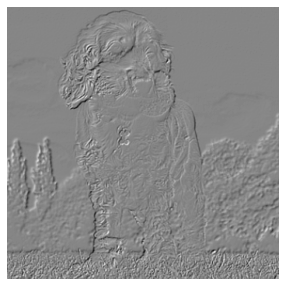

In [27]:
show_image(edge[0], figsize=(5,5));

In [28]:
data.c

37

In [29]:
learn.model
# 3 인풋, 64 아웃풋. 

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

In [30]:
print(learn.summary())
# stride 생각하면서 보기. 

Sequential
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 176, 176]       9,408      False     
______________________________________________________________________
BatchNorm2d          [64, 176, 176]       128        True      
______________________________________________________________________
ReLU                 [64, 176, 176]       0          False     
______________________________________________________________________
MaxPool2d            [64, 88, 88]         0          False     
______________________________________________________________________
Conv2d               [64, 88, 88]         36,864     False     
______________________________________________________________________
BatchNorm2d          [64, 88, 88]         128        True      
______________________________________________________________________
ReLU                 [64, 88, 88]         0          False     
___________________________________________________

## Heatmap

In [0]:
m = learn.model.eval();
# m[0]는 컨볼루션 부분임. 

In [0]:
xb,_ = data.one_item(x)
xb_im = Image(data.denorm(xb)[0])
xb = xb.cuda() # .cuda를 사용하여 데이터를 GPU에 연결하여 모델에 전달할 수 있음. 
# 우리는 이미지를 가지고 있었지만 모델에 직접 제공할 수 없음. 정규화되고 미니 배치로 전환된 다음 GPU에 연결되어야함. 

In [0]:
from fastai.callbacks.hooks import *

In [0]:
def hooked_backward(cat=y):
    with hook_output(m[0]) as hook_a: # m[0]를 파이토치 모듈에 연결.?
        with hook_output(m[0], grad=True) as hook_g:
            preds = m(xb) # 미니 배치 전달. 
            preds[0,int(cat)].backward()
    return hook_a,hook_g
# 파이토치는 이런 연결 고리의 결과를 저장함. 

In [0]:
hook_a,hook_g = hooked_backward() 

In [36]:
acts  = hook_a.stored[0].cpu()
acts.shape
# fastai를 사용하면 컨볼루션 부분은 모델 구조의 첫 번째 위치에 있음. 

torch.Size([512, 11, 11])

In [37]:
avg_acts = acts.mean(0)
avg_acts.shape

torch.Size([11, 11])

In [0]:
def show_heatmap(hm):
    _,ax = plt.subplots()
    xb_im.show(ax)
    ax.imshow(hm, alpha=0.6, extent=(0,352,352,0),
              interpolation='bilinear', cmap='magma');

https://setosa.io/ev/image-kernels

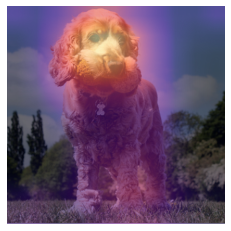

In [39]:
show_heatmap(avg_acts)
# CNN이 어떤 부분에 초점을 맞추었는지 보여주는 그림. 
# fastai를 사용하지 않고 heat map을 작성하는 방법을 배움. 
# pytorch에선 텐서 계산 기능만 사용함.

# RGB에 대해서 다른 커널을 사용하길 원할 것임. 녹색 개구리 탐지기의 경우 녹색에서 더 많은 활성화를 원하는 것처럼. 
# 따라서 3*3*3 커널을 만들어야함. 
# 인풋은 3채널, 아웃풋은 1채널. 

# 11*11*512에서 클래스 갯수(37) 중 하나로 가야함. 
# 모든 11*11의 평균을 취하고 길이 512 벡터를 얻음. 각 채널의 평균을 구함. 
# 512*37의 매트릭스가 37의 벡터로 감. 평균 풀링(average pooling)이라고 함. 

# 512의 평균을 구하면 11*11 행렬을 하나 얻게 된다. 이 행렬의 각 영역은 활성화 수준에 해당. 
# 이게 힛맵임. 평균 활성화 값으로 구성됨. 알파는 투명도. 11*11에서 352*352 사진으로 확장. 

## Grad-CAM

Paper: [Grad-CAM: Visual Explanations from Deep Networks via Gradient-based Localization](https://arxiv.org/abs/1610.02391)

In [40]:
grad = hook_g.stored[0][0].cpu()
grad_chan = grad.mean(1).mean(1)
grad.shape,grad_chan.shape

(torch.Size([512, 11, 11]), torch.Size([512]))

In [0]:
mult = (acts*grad_chan[...,None,None]).mean(0)

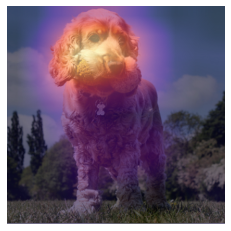

In [42]:
show_heatmap(mult)

In [68]:
path

PosixPath('/root/.fastai/data/oxford-iiit-pet/images')

In [0]:
cp /content/"park.jpg" /root/.fastai/data/oxford-iiit-pet/images # 복순이 이미지를 images 폴더에 복사하였음. 

In [0]:
fn = path/"park.jpg" #Replace with your own image -> 내 이미지 하나 갖다 넣으란 의미였음. 

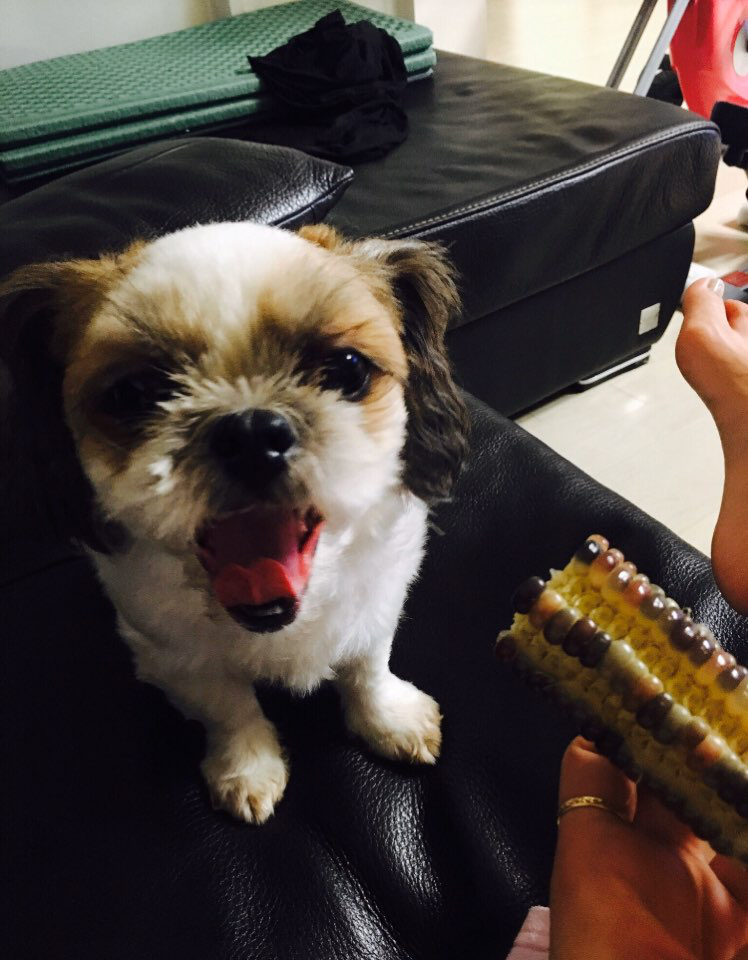

In [71]:
x = open_image(fn); x

In [0]:
xb,_ = data.one_item(x)
xb_im = Image(data.denorm(xb)[0])
xb = xb.cuda()

In [0]:
hook_a,hook_g = hooked_backward()

In [0]:
acts = hook_a.stored[0].cpu()
grad = hook_g.stored[0][0].cpu()

grad_chan = grad.mean(1).mean(1)
mult = (acts*grad_chan[...,None,None]).mean(0)

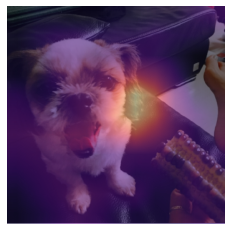

In [75]:
show_heatmap(mult)

In [76]:
data.classes[0]

'Abyssinian'

In [0]:
hook_a,hook_g = hooked_backward(0)

In [0]:
acts = hook_a.stored[0].cpu()
grad = hook_g.stored[0][0].cpu()

grad_chan = grad.mean(1).mean(1)
mult = (acts*grad_chan[...,None,None]).mean(0)

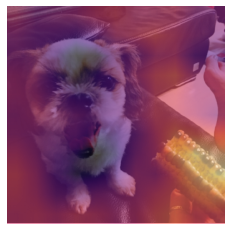

In [79]:
show_heatmap(mult)

## fin